# Toxicity Type Detection

In this notebook, we will train a baseline model to predict the toxicity types of toxic comments.

We will use [simpletransformers](https://simpletransformers.ai/) that is a wrapper for many popular models available in [Hugging Face](https://huggingface.co/).

We will use a pre-trained model ([neuralmind/bert-base-portuguese-cased · Hugging Face](https://huggingface.co/neuralmind/bert-base-portuguese-cased)) that is trained on Portuguese.

In [9]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent.parent))

In [10]:
from dotenv import load_dotenv

# Initialize the env vars
load_dotenv("../../.env")

True

In [11]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda import is_available
from sklearn.metrics import classification_report
from simpletransformers.classification import (
    MultiLabelClassificationModel,
    MultiLabelClassificationArgs
)

from src.kaggle import download_dataset
from src.modeling.utils import (
    prep_data,
    clean_simpletransformers,
    compute_pos_weight,
    get_labels_for_y
)

%matplotlib inline

sns.set_theme(style="whitegrid", palette="pastel")

logging.basicConfig(level=logging.INFO)

_logger = logging.getLogger("transformers")
_logger.setLevel(logging.WARNING)

params = {
    "seed": 1993,
    "model_type": "bert",
    "model_name": "neuralmind/bert-base-portuguese-cased",
    "num_train_epochs": 6,
    "use_cuda": is_available()
}

## Load the data

In this section, we will download the data and load it into a pandas dataframe.

In [12]:
files = download_dataset(
    ["train.csv", "test.csv"]
)

train_data = files["train.csv"]
test_data = files["test.csv"]

print(f"Training set: {train_data.shape}")
train_data.head()

Training set: (4765, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,430b13705cf34e13b74bc999425187c3,USER USER é muito bom. USER ^^ E claro a equip...,NOT,UNT,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False
1,c779826dc43f460cb18e8429ca443477,Pior do que adolescentezinhas de merda...são p...,OFF,UNT,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,True,False,False,True,False
2,e64148caa4474fc79298e01d0dda8f5e,USER Toma no cu é vitamina como tu e tua prima.,OFF,TIN,GRP,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",False,False,True,False,False,False,True,False,False,False,False
3,cc66b54eeec24607a67e2259134a1cdd,"Muito bom, pena a circunstâncias serem ruins, ...",OFF,UNT,NaN,"[119, 120, 121, 122, 123, 124, 125, 126, 127, ...",False,False,True,False,False,False,False,False,False,False,False
4,a3d7839456ae4258a70298fcf637952e,"Podia ter beijo também, pra ver se o homofóbic...",OFF,UNT,NaN,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...",False,False,True,False,False,False,False,False,False,False,False


In [13]:
print(f"Test set: {test_data.shape}")
test_data.head()

Test set: (1589, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,da19df36730945f08df3d09efa354876,USER Adorei o comercial também Jesus. Só achei...,OFF,UNT,NaN,"[52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 6...",False,False,True,False,False,False,True,False,False,False,False
1,80f1a8c981864887b13963fed1261acc,Cara isso foi muito babaca geral USER conhece ...,OFF,TIN,GRP,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,False,False,False,False,False
2,2f67025f913e4a6292e3d000d9e2b5a8,"Se vc for porco, folgado e relaxado, você não ...",OFF,UNT,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,False,False,False,False,False
3,738ccd4476784f47af3a5a6cfdda4695,Se fosse um sniper ia ser louco,OFF,UNT,NaN,"[26, 27, 28, 29, 30]",False,False,True,False,False,True,False,False,False,False,False
4,e0064da693bd4c9e90ce8e6db8bd3bbb,USER é o meu saco USER USER USER,OFF,UNT,NaN,"[13, 14, 15, 16]",False,False,True,False,False,False,True,False,False,False,False


In [14]:
toxicity_labels = [
    "health",
    "ideology",
    "insult",
    "lgbtqphobia",
    "other_lifestyle",
    "physical_aspects",
    "profanity_obscene",
    "racism",
    "sexism",
    "xenophobia"
]

def filter_data(df: pd.DataFrame):
    # Filter only offensive comments
    df = df[df["is_offensive"] == "OFF"]

    # Remove religious_intolerance that has only one  sample
    df = df[df["religious_intolerance"] == False]

    df.drop(columns=["religious_intolerance"], inplace=True)

    # Filter only offensive comments with at least one toxicity label
    df = df.loc[df.select_dtypes('bool').sum(axis=1).ge(1)]

    df.reset_index(drop=True, inplace=True)
    return df

train_data = filter_data(train_data)
test_data = filter_data(test_data)

print(f"Shape: {train_data.shape}")
print(f"Shape: {test_data.shape}")

Shape: (4272, 16)
Shape: (1438, 16)


## Exploratory Data Analysis (EDA)

In the next section, we will perform some exploratory data analysis (EDA) to understand the data.

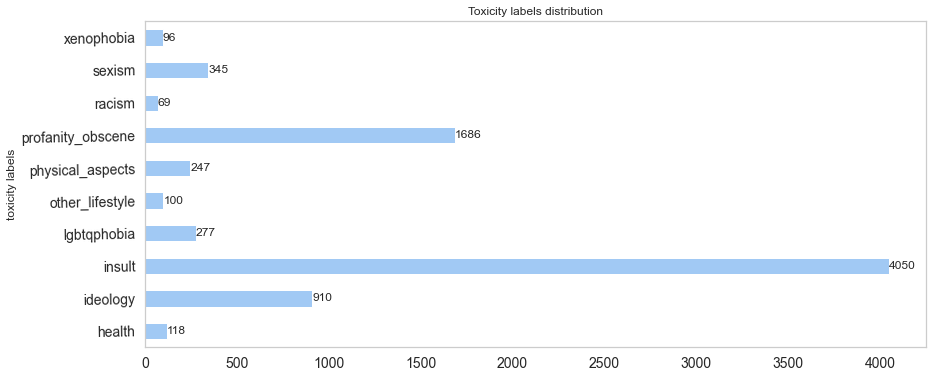

In [15]:
df_eda = train_data[["text"]+toxicity_labels]

ax = df_eda[toxicity_labels].sum().plot(kind="barh", grid=False,
                                        legend=False, figsize=(14, 6),
                                        xlabel="toxicity labels", ylabel="count", fontsize=14,
                                        rot=1, title="Toxicity labels distribution")

for container in ax.containers:
    ax.bar_label(container, fontsize=12)

## Prepare the data

In this section, we will prepare the data in order to train the model.

The `simpletransformers` library expects the data in a specific format.

More information about the format can be found in the [Classification Data Formats - Simple Transformers](https://simpletransformers.ai/docs/classification-data-formats/#binary-classification)

In [14]:
X_train = train_data["text"].values
y_train = train_data[toxicity_labels].astype(int).values

X_test = test_data["text"].values
y_test = test_data[toxicity_labels].astype(int).values

train_data = prep_data(X_train, y_train)
test_data = prep_data(X_test, y_test)

df_train = pd.DataFrame(train_data)
df_train.columns = ["text", "labels"]

df_test = pd.DataFrame(test_data)
df_test.columns = ["text", "labels"]

print(f"train_data: {df_train.shape}")
print(f"test_data: {df_test.shape}")

train_data: (4272, 2)
test_data: (1438, 2)


## Training the model

In this section, we will train a baseline model to predict if a toxic comment is targeted or not.

We will not perform hyperparameter tuning because it is a simple baseline model.

In [15]:
clean_simpletransformers()
        
# Compute class weights
params["pos_weights"] = compute_pos_weight(y_train)

# Optional model configuration
model_args = MultiLabelClassificationArgs(
    num_train_epochs=params["num_train_epochs"])

# Create a ClassificationModel
model = MultiLabelClassificationModel(
    model_type=params["model_type"],
    model_name=params["model_name"],
    num_labels=len(toxicity_labels),
    args=model_args,
    pos_weight=params["pos_weights"],
    use_cuda=params["use_cuda"]
)

# Train the model
model.train_model(df_train)

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClas

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

  0%|          | 0/4272 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_utils.py:267: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  labels = torch.tensor(labels, dtype=torch.long)


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/534 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/534 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/534 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/534 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/534 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/534 [00:00<?, ?it/s]

(3204, 0.5144644268374476)

## Evaluating the model

In this section, we will evaluate the model with the following metrics:

- **Accuracy**: the percentage of correct predictions;
- **Precision**: the percentage of predicted targeted comments that are actually targeted;
- **Recall**: the percentage of targeted comments that are actually predicted as targeted;
- **F1-Score**: the harmonic mean of precision and recall;
- **ROC AUC**: the area under the receiver operating characteristic Curve (ROC AUC).

In [17]:
result, model_outputs, wrong_predictions = model.eval_model(df_test)

y_true = df_test["labels"].tolist()

y_pred, raw_outputs = model.predict(df_test["text"].tolist())

result

  0%|          | 0/1438 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1438 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

{'LRAP': 0.8798813663156496, 'eval_loss': 1.3377905303612352}

In [20]:
print(
    classification_report(
        y_test, y_pred,
        target_names=toxicity_labels,
        digits=4, zero_division=0
    )
)

                   precision    recall  f1-score   support

           health     0.2931    0.4359    0.3505        39
         ideology     0.7254    0.6776    0.7007       304
           insult     0.9825    0.6640    0.7924      1351
      lgbtqphobia     0.7188    0.7500    0.7340        92
  other_lifestyle     0.5000    0.3529    0.4138        34
 physical_aspects     0.5055    0.5542    0.5287        83
profanity_obscene     0.7201    0.7598    0.7394       562
           racism     0.5000    0.4783    0.4889        23
           sexism     0.3873    0.4783    0.4280       115
       xenophobia     0.4848    0.5000    0.4923        32

        micro avg     0.7784    0.6664    0.7181      2635
        macro avg     0.5817    0.5651    0.5669      2635
     weighted avg     0.8200    0.6664    0.7265      2635
      samples avg     0.8275    0.7189    0.7307      2635



## Testing the model

In the last section, we will test the model with some comments from the test set.

In [18]:
df_pred = df_test.head(30)

predictions, raw_outputs = model.predict(df_pred["text"].tolist())

df_pred = df_pred.assign(predictions=predictions)

df_pred["labels"] = df_pred["labels"].apply(lambda x: get_labels_for_y(x, toxicity_labels))
df_pred["predictions"] = df_pred["predictions"].apply(lambda x: get_labels_for_y(x, toxicity_labels))

df_pred.to_csv("pred.csv", index=False, encoding="utf-8")

df_pred

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,text,labels,predictions
0,USER Adorei o comercial também Jesus. Só achei...,"[insult, profanity_obscene]",[lgbtqphobia]
1,Cara isso foi muito babaca geral USER conhece ...,[insult],[profanity_obscene]
2,"Se vc for porco, folgado e relaxado, você não ...",[insult],[insult]
3,Se fosse um sniper ia ser louco,"[insult, physical_aspects]",[insult]
4,USER é o meu saco USER USER USER,"[insult, profanity_obscene]",[profanity_obscene]
5,"Vergonha,ainda segura a bandeira de um país de...","[ideology, insult, lgbtqphobia, xenophobia]","[ideology, insult]"
6,"USER Que vagabunda hipócrita, pq eu beijei as ...","[insult, profanity_obscene, sexism]",[profanity_obscene]
7,"USER USER, exatamente. E quem abusa pra caralh...","[ideology, insult, profanity_obscene]","[ideology, profanity_obscene, xenophobia]"
8,Não vai arrumar trabalho nem de limpar bosta d...,"[insult, profanity_obscene]",[insult]
9,"O diabo é sujo mesmo, ele tem orgulho de conta...",[insult],[insult]


In [19]:
clean_simpletransformers()